In [20]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch
import sys
from argparse import ArgumentParser
import trimesh
import cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%cd ../deps/neural-head-avatars

/home/dmitry/clones/PanoHead-clostra/deps/neural-head-avatars


# Loading dataset and model

In [6]:
from nha.data.real import RealDataModule
from nha.models.nha_optimizer import NHAOptimizer, create_camera_objects
from nha.util.general import dict_2_device
from nha.util.render import batch_project, normalize_image_points, unnormalize_image_points
import pytorch_lightning as pl
from pytorch3d.structures import Meshes
from configargparse import ArgumentParser as ConfigArgumentParser

In [7]:
optimizer_module = NHAOptimizer
data_module = RealDataModule

parser = ArgumentParser()
parser = optimizer_module.add_argparse_args(parser)
parser = data_module.add_argparse_args(parser)
parser = pl.Trainer.add_argparse_args(parser)

parser = ConfigArgumentParser(parents=[parser], add_help=False)
parser.add_argument('--config', required=True, is_config_file=True)
parser.add_argument("--checkpoint_file", type=str, required=False, default="",
                    help="checkpoint to load model from")

path = Path("/home/dmitry/clones/PanoHead-clostra/dataset/dmitry_input")
path = path.absolute()

tracking_results_path = path / 'ds' / 'tracking_results'
tracking_results_list = list(tracking_results_path.iterdir())
tracking_results_list.sort()
args = parser.parse_args([
    '--config', 'configs/optimize_avatar_mesh_guidance.ini',
    # DEBUG
    '--config', 'configs/optimize_avatar_mesh_guidance.ini', 
    '--default_root_dir', str(path / 'ds' / 'results'),
    '--tracking_results_path', str(tracking_results_list[-1] / 'tracked_flame_params.npz'),
    '--data_path', str(path / 'ds'),
    '--gpus', '1',
    '--load_threeddfa', str(path / 'dataset.json'),
    '--mesh', str(path / 'pti_out' / 'PTI_render' / 'post_mesh_level2' / 'mesh.obj'),
    '--checkpoint_file', "/home/dmitry/clones/PanoHead-clostra/dataset/dmitry_input/ds/results/lightning_logs/version_22/checkpoints/last.ckpt"

])
args_dict = vars(args)

# print(f"Start Model training with the following configuration: \n {parser.format_values()}")

# init datamodule
data = data_module(**args_dict)
data.setup()

# init optimizer
args_dict['max_frame_id'] = data.max_frame_id

if args.checkpoint_file:
    model = optimizer_module.load_from_checkpoint(args.checkpoint_file, strict=True, **args_dict)
else:
    model = optimizer_module(**args_dict)

model.cuda();

/home/dmitry/.miniconda3/envs/panohead/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: ModelCheckpoint(save_last=True, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  warnings.warn(*args, **kwargs)


# Visualize predicted landmarks

In [13]:
sample = data._train_set[0]
sample.keys()

dict_keys(['frame', 'subject', 'rgb', 'seg', 'lmk2d', 'lmk2d_iris', 'flame_shape', 'flame_expr', 'flame_pose', 'flame_trans', 'flame_scale', 'cam_intrinsic', 'cam_extrinsic', 'normal', 'parsing', 'valid_eyes', 'eye_distance'])

In [30]:
lmks_gt = sample["lmk2d"].cpu().numpy()
rgb = sample["rgb"].cpu().numpy().transpose(1, 2, 0).copy() * 0.5 + 0.5

In [31]:
for x,y in lmks_gt[:, :2]:
    cv2.circle(rgb, (int(x), int(y)), 3, (255, 0, 0), -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


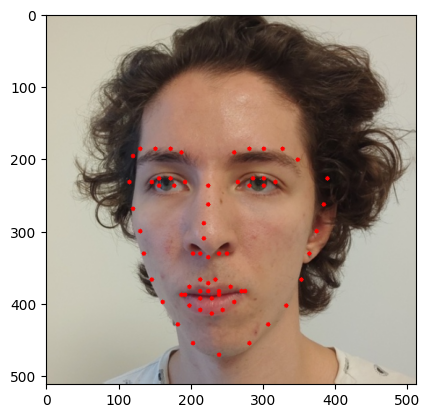

In [32]:
plt.imshow(rgb)